<a href="https://colab.research.google.com/github/PeraHive/project-redspot/blob/main/Test_Simulation_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

STATUS: Beacon not in FOV - Searching...


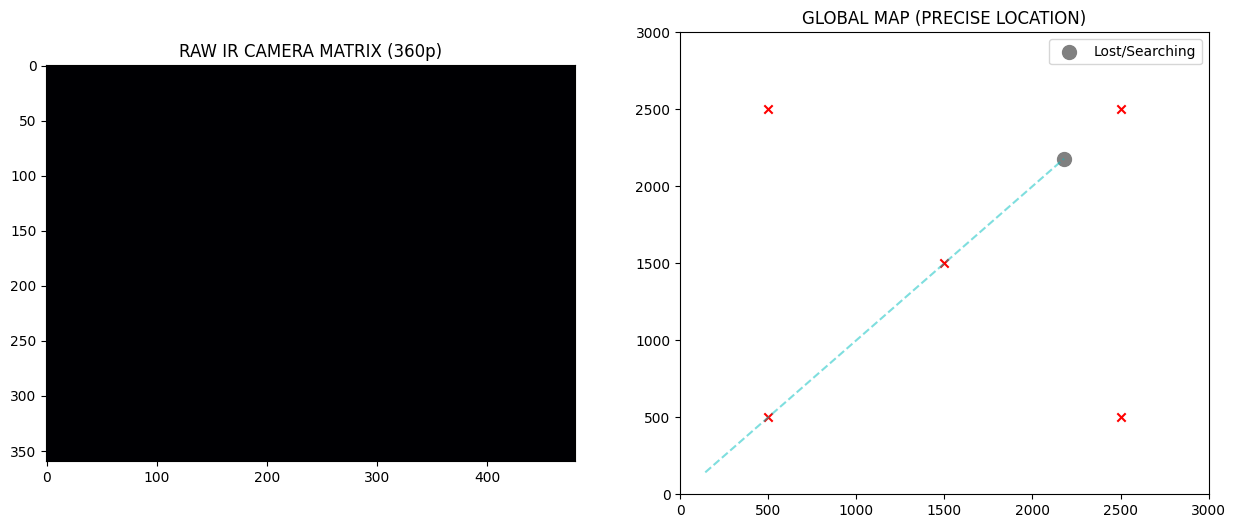

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

# --- 1. GLOBAL MAP DATA (Obtained before flight) ---
MAP_SIZE = 3000  # Map matrix units
# Known coordinates of IR Beacons (The map data)
BEACON_MAP = {
    "ID_0": np.array([500.0, 500.0]),
    "ID_1": np.array([2500.0, 500.0]),
    "ID_2": np.array([1500.0, 1500.0]),
    "ID_3": np.array([500.0, 2500.0]),
    "ID_4": np.array([2500.0, 2500.0])
}

# --- 2. CAMERA PARAMETERS ---
IMG_W, IMG_H = 480, 360  # Raw IR Camera Matrix size
FOCAL_LENGTH = 400       # Lens characteristic
ALTITUDE = 100           # Current drone height

# Drone State (Internal hidden variables for simulation)
real_pos = np.array([100.0, 100.0])
target_waypoint = np.array([2800.0, 2800.0]) # Flight destination

def capture_ir_matrix(current_real_pos):
    """Generates the raw IR camera matrix (The only data the drone 'sees')"""
    # Create blank sensor matrix
    ir_matrix = np.zeros((IMG_H, IMG_W), dtype=np.uint8)

    for id, b_pos in BEACON_MAP.items():
        # Relative distance in world units
        dx, dy = b_pos - current_real_pos
        # Project to pixels: P_px = (D_world * Focal) / Altitude + Center
        px = int((dx * FOCAL_LENGTH / ALTITUDE) + (IMG_W / 2))
        py = int((dy * FOCAL_LENGTH / ALTITUDE) + (IMG_H / 2))

        # If the IR light hits the sensor matrix
        if 0 <= px < IMG_W and 0 <= py < IMG_H:
            cv2.circle(ir_matrix, (px, py), 10, 255, -1) # IR Beacon Blob

    return ir_matrix

def localize_from_sensor(ir_matrix):
    """The Logic: Takes RAW Matrix -> Outputs Precise Map Coordinates"""
    # 1. Detect Beacon Centroid (Image Processing)
    moments = cv2.moments(ir_matrix)
    if moments["m00"] < 1: return None # No beacon detected

    cX = moments["m10"] / moments["m00"]
    cY = moments["m01"] / moments["m00"]

    # 2. Identify which beacon it is (In this sim, we pick the closest known)
    # In the thesis, this is done via frequency modulation or proximity

    # 3. Calculate Real-World Offset from Centroid
    # Pinhole Formula: World_Dist = (Pixel_Offset * Altitude) / Focal
    offset_x_world = (cX - (IMG_W / 2)) * ALTITUDE / FOCAL_LENGTH
    offset_y_world = (cY - (IMG_H / 2)) * ALTITUDE / FOCAL_LENGTH

    # Since we know beacon map pos, Drone_Pos = Beacon_Pos - Offset
    # For sim, we'll assume we are near Beacon ID_2 if multiple aren't used
    ref_beacon = BEACON_MAP["ID_2"]
    # (Note: In a full map, you'd iterate to find which beacon matches the location)

    precise_x = ref_beacon[0] - offset_x_world
    precise_y = ref_beacon[1] - offset_y_world

    return np.array([precise_x, precise_y])

# --- 3. LIVE SIMULATION ---
path = []
for i in range(50):
    # Move drone toward target (Simulating flight)
    dir_vec = target_waypoint - real_pos
    real_pos += (dir_vec / np.linalg.norm(dir_vec)) * 60 # Flight speed
    path.append(real_pos.copy())

    # SENSOR STEP: Get the IR Matrix
    raw_sensor_data = capture_ir_matrix(real_pos)

    # LOCALIZATION STEP: Calculate Precise Map Location
    estimated_pos = localize_from_sensor(raw_sensor_data)

    if i % 3 == 0: # Efficient rendering
        clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        ax1.set_title("RAW IR CAMERA MATRIX (360p)")
        ax1.imshow(raw_sensor_data, cmap='inferno')

        ax2.set_title("GLOBAL MAP (PRECISE LOCATION)")
        ax2.set_xlim(0, MAP_SIZE); ax2.set_ylim(0, MAP_SIZE)
        # Draw Beacons
        for id, b in BEACON_MAP.items(): ax2.scatter(b[0], b[1], c='red', marker='x')
        # Draw Drone
        ax2.plot([p[0] for p in path], [p[1] for p in path], 'c--', alpha=0.5)
        if estimated_pos is not None:
            ax2.scatter(estimated_pos[0], estimated_pos[1], c='lime', s=100, label='Localized')
            print(f"PRECISE LOCATION FOUND: X={estimated_pos[0]:.2f}, Y={estimated_pos[1]:.2f}")
        else:
            ax2.scatter(real_pos[0], real_pos[1], c='gray', s=100, label='Lost/Searching')
            print("STATUS: Beacon not in FOV - Searching...")

        plt.legend()
        plt.show()
        time.sleep(0.05)